***
# DSCI 100: Group Project Proposal
## Generation and Assessment of a Classification Model for Secondary Students' Alcohol Consumption 

#### **Section 006 - Group 6**
#### Authors: Duncan Harrop, Julia Sangster, Charisse Webb, Janelle Xie
***

## **Introduction**
***

Alcohol consumption has been related to poor academic performance in university and secondary-school students [2, 3]. To avoid self-reporting bias from students, this project aims to identify non-self-reported measures that can accurately classify a student's alcohol consumption.

In 2008, data was collected from Portuguese secondary schools via mark reports and questionnaires [1]. Students rated their weekday (`Dalc`) and weekend (`Walc`) alcohol consumption discretely. Various factors were used to predict final marks of the students. 

The data set will be repurposed to answer the following question: given non-self-reported measures of a student (age, grades, sex, failures, number of absences) what is the severity of the student's alcohol consumption on a scale of 2-10? Further, the accuracy of the classifier will be evaluated. 

***
## **Preliminary Exploratory Data Analysis**
***

### Notebook Setup

In [1]:
## This cell does all set-up steps for analysis 

## NOTE: Uncomment these lines if you do not have tidyverse, repr or tidymodels package installed
#install.packages("tidyverse")
#install.packages("repr")
#install.packages("tidymodels")

## The following lines load all relevant packages for analysis
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(repr))
suppressPackageStartupMessages(library(tidymodels))

## Reducing default table output size 
options(repr.matrix.max.rows = 6)
    
## Setting the RNG seed for analysis
set.seed(9999)

## Setting theme for output
theme_set(theme_bw())

### Reading Data from Web Repository

In [2]:
suppressWarnings({
      
    ## Reading file from GitHub project repository
    student_alcohol_consumption_raw <- read_csv("https://raw.githubusercontent.com/juliasangster/DSCI_Project/main/data/student-mat.csv", col_types = cols())
    
    ## Displaying a part of the loaded data
    head(student_alcohol_consumption_raw)
    })

school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,4,3,4,1,1,3,6,5,6,6
GP,F,17,U,GT3,T,1,1,at_home,other,⋯,5,3,3,1,1,3,4,5,5,6
GP,F,15,U,LE3,T,1,1,at_home,other,⋯,4,3,2,2,3,3,10,7,8,10
GP,F,15,U,GT3,T,4,2,health,services,⋯,3,2,2,1,1,5,2,15,14,15
GP,F,16,U,GT3,T,3,3,other,other,⋯,4,3,2,1,2,5,4,6,10,10
GP,M,16,U,LE3,T,4,3,services,other,⋯,5,4,2,1,2,5,10,15,15,15


### Cleaning/Wrangling Data:

The raw dataset contains no `NA` values, as shown below.

In [3]:
number_observations_total <- nrow(student_alcohol_consumption_raw)

data_na <- student_alcohol_consumption_raw |>
    filter_if(is.numeric, any_vars(is.na(.)))

number_rows_containing_na <- nrow(data_na)

if(is.null(data_na)) {
    number_rows_containing_na = 0}


print("The total number of rows is:")
print(number_observations_total)
print("The number of rows containing NA values is:")
print(number_rows_containing_na)


[1] "The total number of rows is:"
[1] 395
[1] "The number of rows containing NA values is:"
[1] 0


#### Wrangling Steps

1. Selected relevant columns for preliminary analysis
2. Created a `Talc` column as the sum of `Dalc` and `Walc`
3. Calculated and stored the average of academic assessments in column `AvgG`
4. Converted discrete variables `sex`, `Talc`, and `failures` to `fct` data type
5. Selected relevant columns for final analysis

In [4]:
## Step 1
## Select relevant columns for preliminary analysis
student_alcohol_consumption <- student_alcohol_consumption_raw |>
    select(sex, age, failures, Dalc, Walc, absences, G1, G2, G3)

In [5]:
## Step 2
## Convert weekend and weekday alcohol consumption to weekly total alcohol consumption 
student_alcohol_consumption <- student_alcohol_consumption |>
    mutate(Talc = Dalc + Walc) 

In [6]:
## Step 3
## Convert individual grade assessments to average grade assessment 
student_alcohol_consumption <- student_alcohol_consumption |>
    mutate(AvgG = (G1 + G2 + G3)/3)

In [7]:
## Step 4
## Convert discrete variables to factor type 
student_alcohol_consumption$Talc <- as.factor(student_alcohol_consumption$Talc)
student_alcohol_consumption$failures <- as.factor(student_alcohol_consumption$failures)
student_alcohol_consumption$sex <- as.factor(student_alcohol_consumption$sex)

In [8]:
## Step 5
## Select relevant columns for final analysis
student_alcohol_consumption <- student_alcohol_consumption |>
    select(-Dalc, - Walc, -G1, -G2, -G3) 

#### Splitting the Dataset

The dataset was then split into training (75%) and testing (25%) data-sets.

In [9]:
## Splitting data into testing/training data frames
sac_split <- initial_split(student_alcohol_consumption, 
                            prop = 0.75,
                            strata = Talc)

## Grabbing the training set in a single data frame
sac_train <- training(sac_split)

## Grabbing the testing set in a single data frame
sac_test  <- testing(sac_split)

sac_split

<Training/Testing/Total>
<294/101/395>

The next section will focus on describing our wrangled training dataset.

In [10]:
head(sac_train)

sex,age,failures,absences,Talc,AvgG
<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>
F,15,0,2,2,14.666667
F,17,0,6,2,5.666667
M,15,0,0,2,17.666667
M,15,0,0,2,14.666667
F,15,0,4,2,11.333333
M,15,0,0,2,15.333333


### Summarizing and Visualizing Training Data 

In the analysis to be conducted, the predictors are `age`, `sex`, `failures`, `absences`, and `AvgG`. Distributions of these variables in relation to `Talc` were generated.

#### Investigating Total Weekly Alcohol Consumption in Training Data

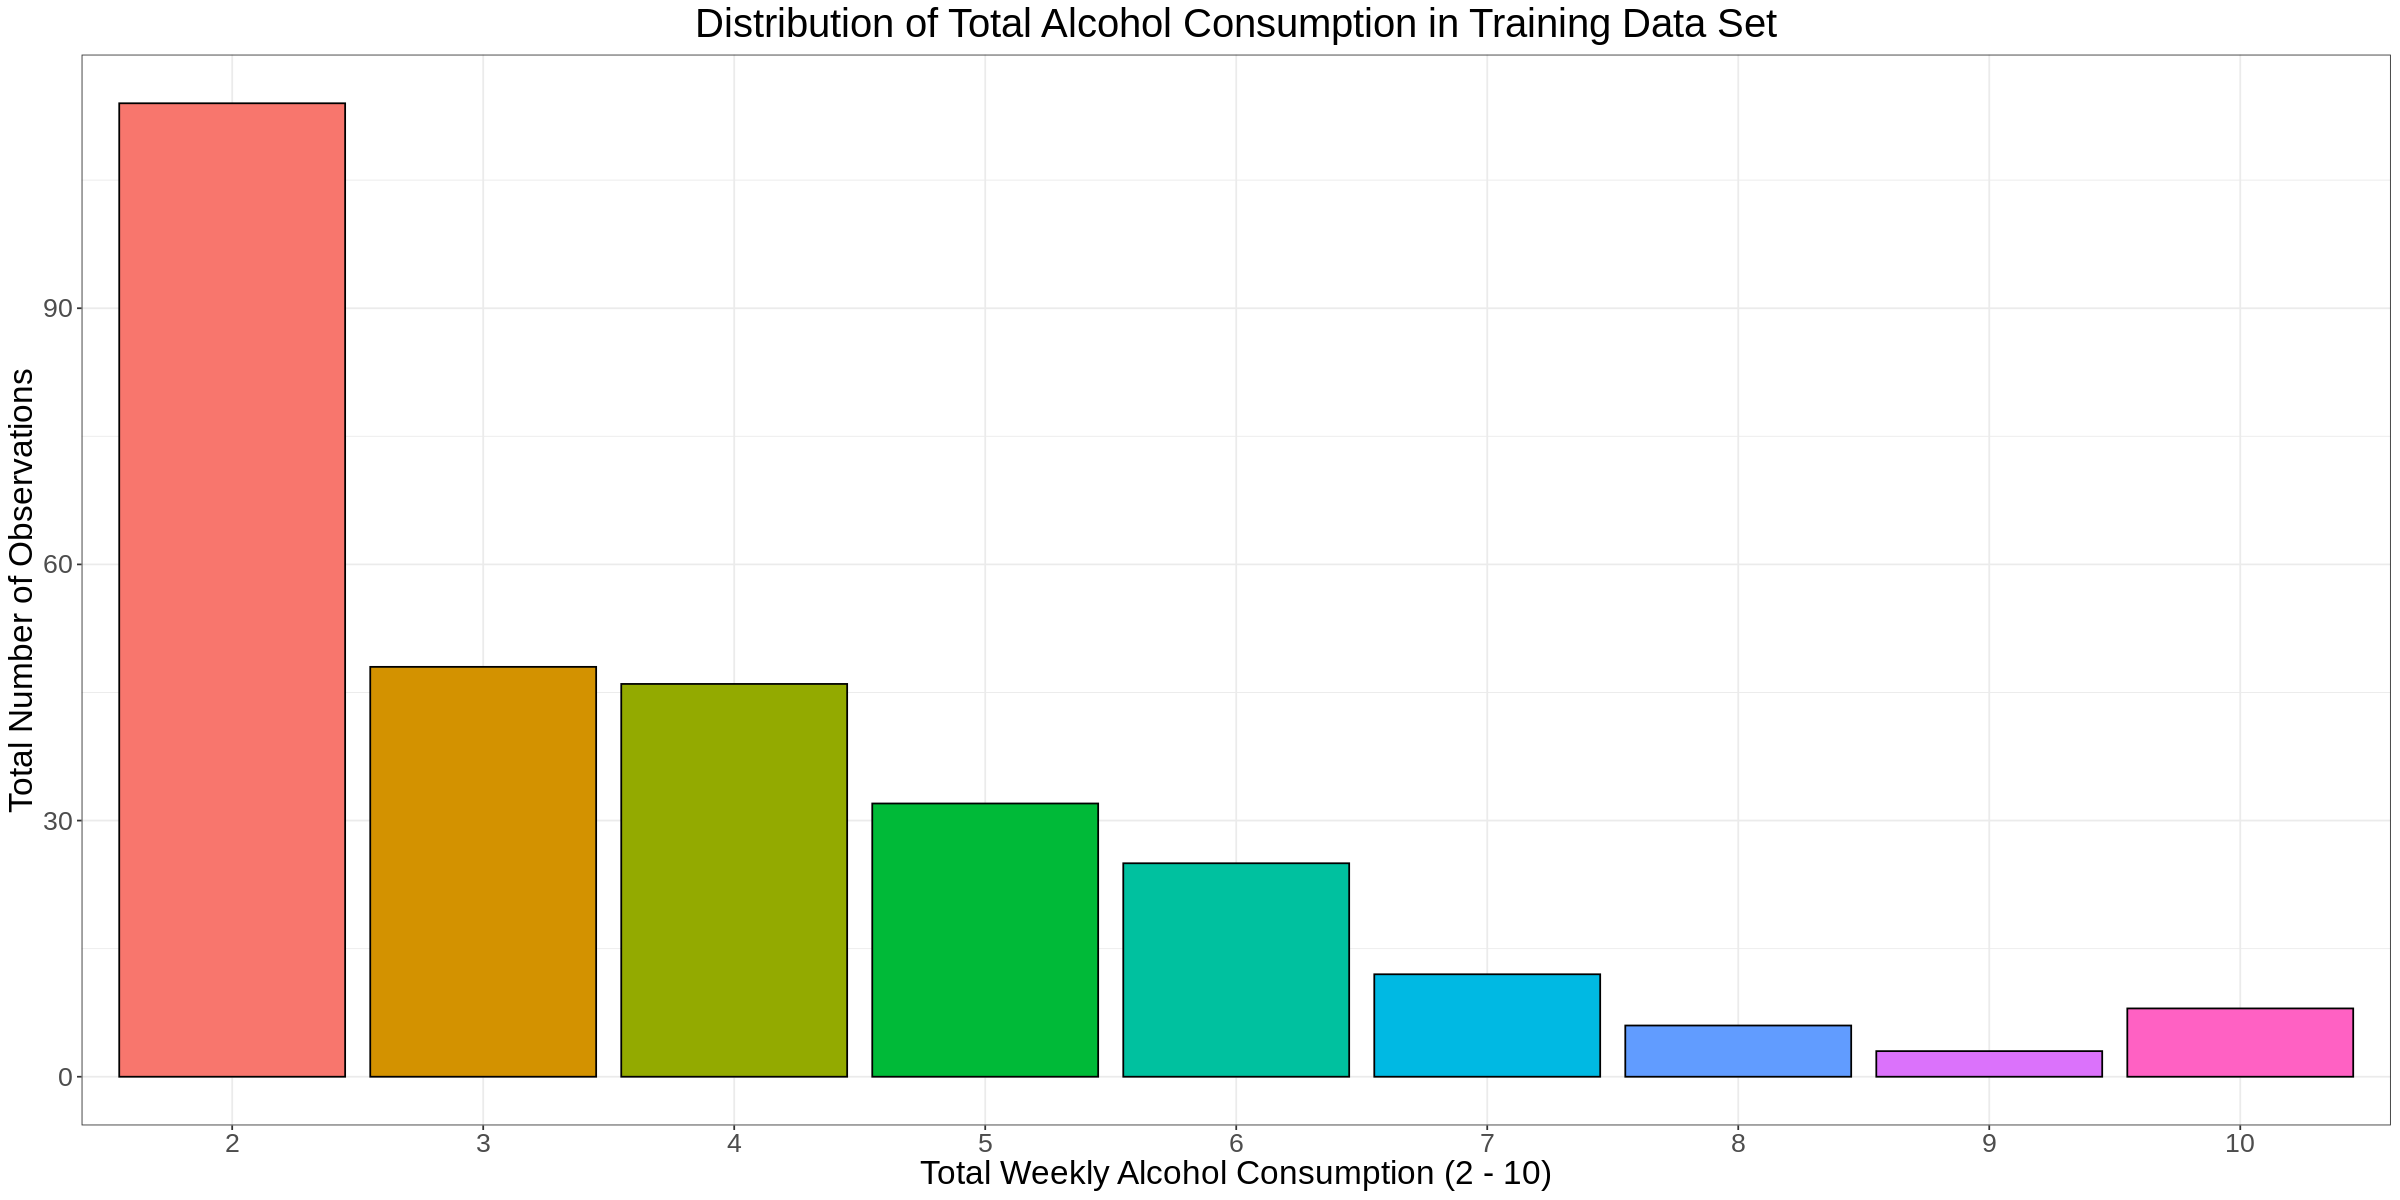

In [11]:
alcohol_consump_data <- sac_train |>
    select(Talc) 

options(repr.plot.width = 20, repr.plot.height = 10) 

suppressWarnings({
alcohol_consump_plot <- alcohol_consump_data |>
    ggplot(aes(x = Talc)) +
    geom_histogram(aes(fill = Talc), color = "black", stat = "count") +
    xlab("Total Weekly Alcohol Consumption (2 - 10)") +
    ylab("Total Number of Observations") +
    ggtitle("Distribution of Total Alcohol Consumption in Training Data Set") +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size = 20),
         legend.position = "none")
})

alcohol_consump_plot

The distribution is right-skewed, with more observations in lower `Talc` levels.

#### Investigating Total Weekly Alcohol Consumption Distribution in Male vs. Female Students

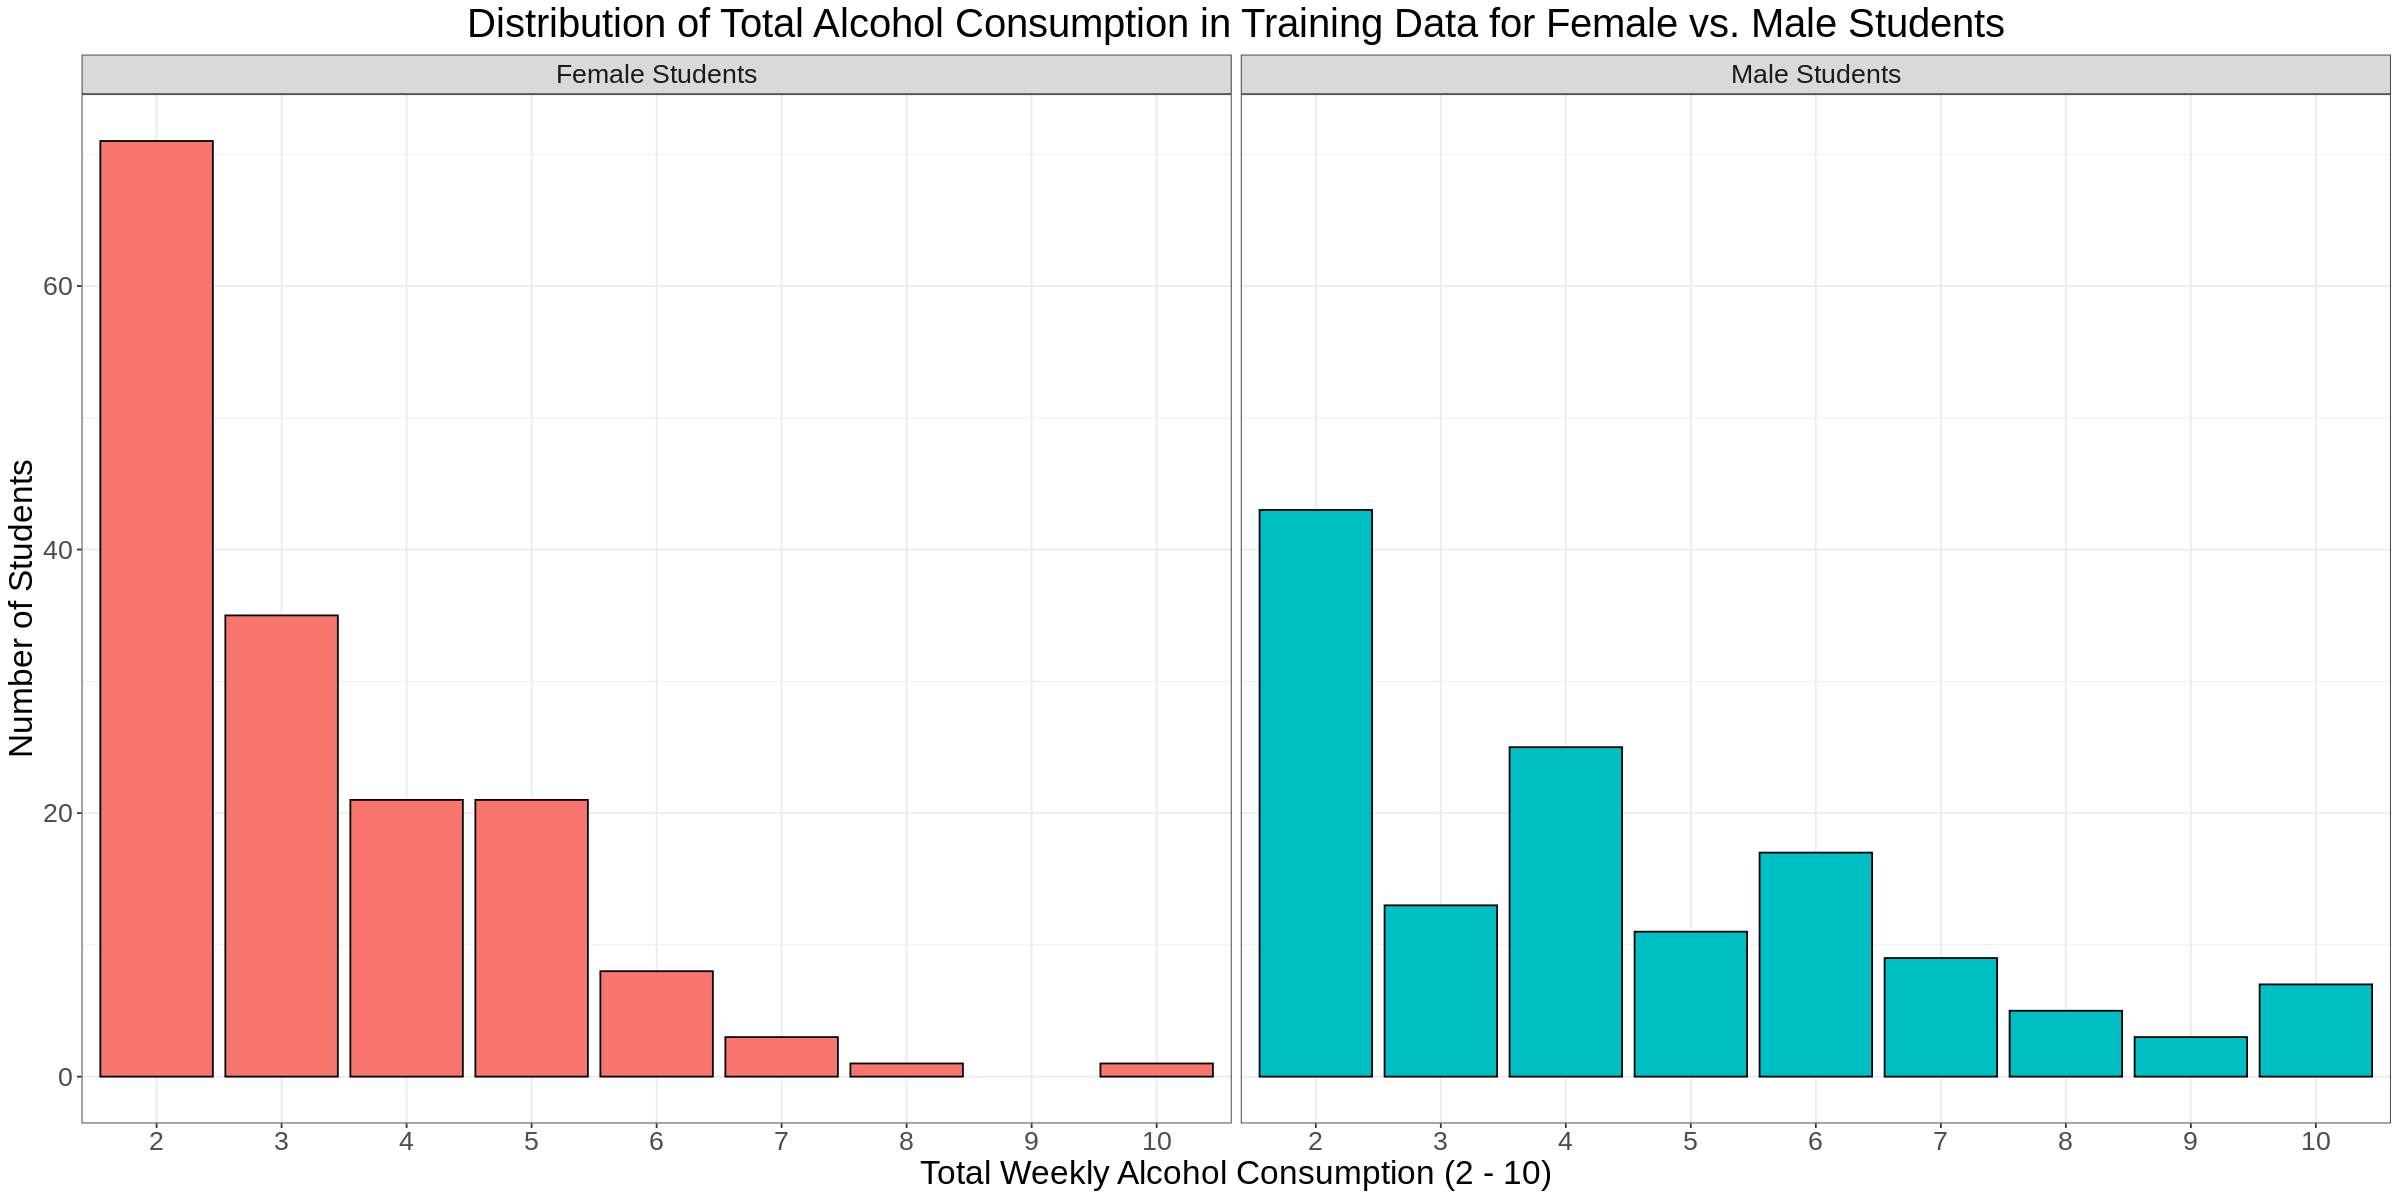

In [12]:
sac_train_sex_distribution_chart_data <- sac_train |>
    select(Talc, sex) |>
    group_by(Talc, sex) |>
    summarize(count = n(), .groups = "keep")
    

## Code for plot: 
options(repr.plot.width = 20, repr.plot.height = 10) 
sac_train_sex_distribution_chart_data$sex <- factor(sac_train_sex_distribution_chart_data$sex, levels = c("F","M"),
                                                    labels = c("Female Students", "Male Students"))

sac_train_sex_distribution_chart <- sac_train_sex_distribution_chart_data |>
     ggplot(aes(x = Talc, y = count, fill = sex)) + 
     geom_bar(stat = "identity",
             color = "black") +
     facet_grid(cols = vars(sex)) +
     labs(x = "Total Weekly Alcohol Consumption (2 - 10)",
          y = "Number of Students",
          title = "Distribution of Total Alcohol Consumption in Training Data for Female vs. Male Students") +
     theme(plot.title = element_text(hjust = 0.5),
           text = element_text(size = 20),
           legend.position = "none")


sac_train_sex_distribution_chart


Visually, it appears male students have higher average `Talc`.

#### Investigating Age of Students in Different `Talc` Groups

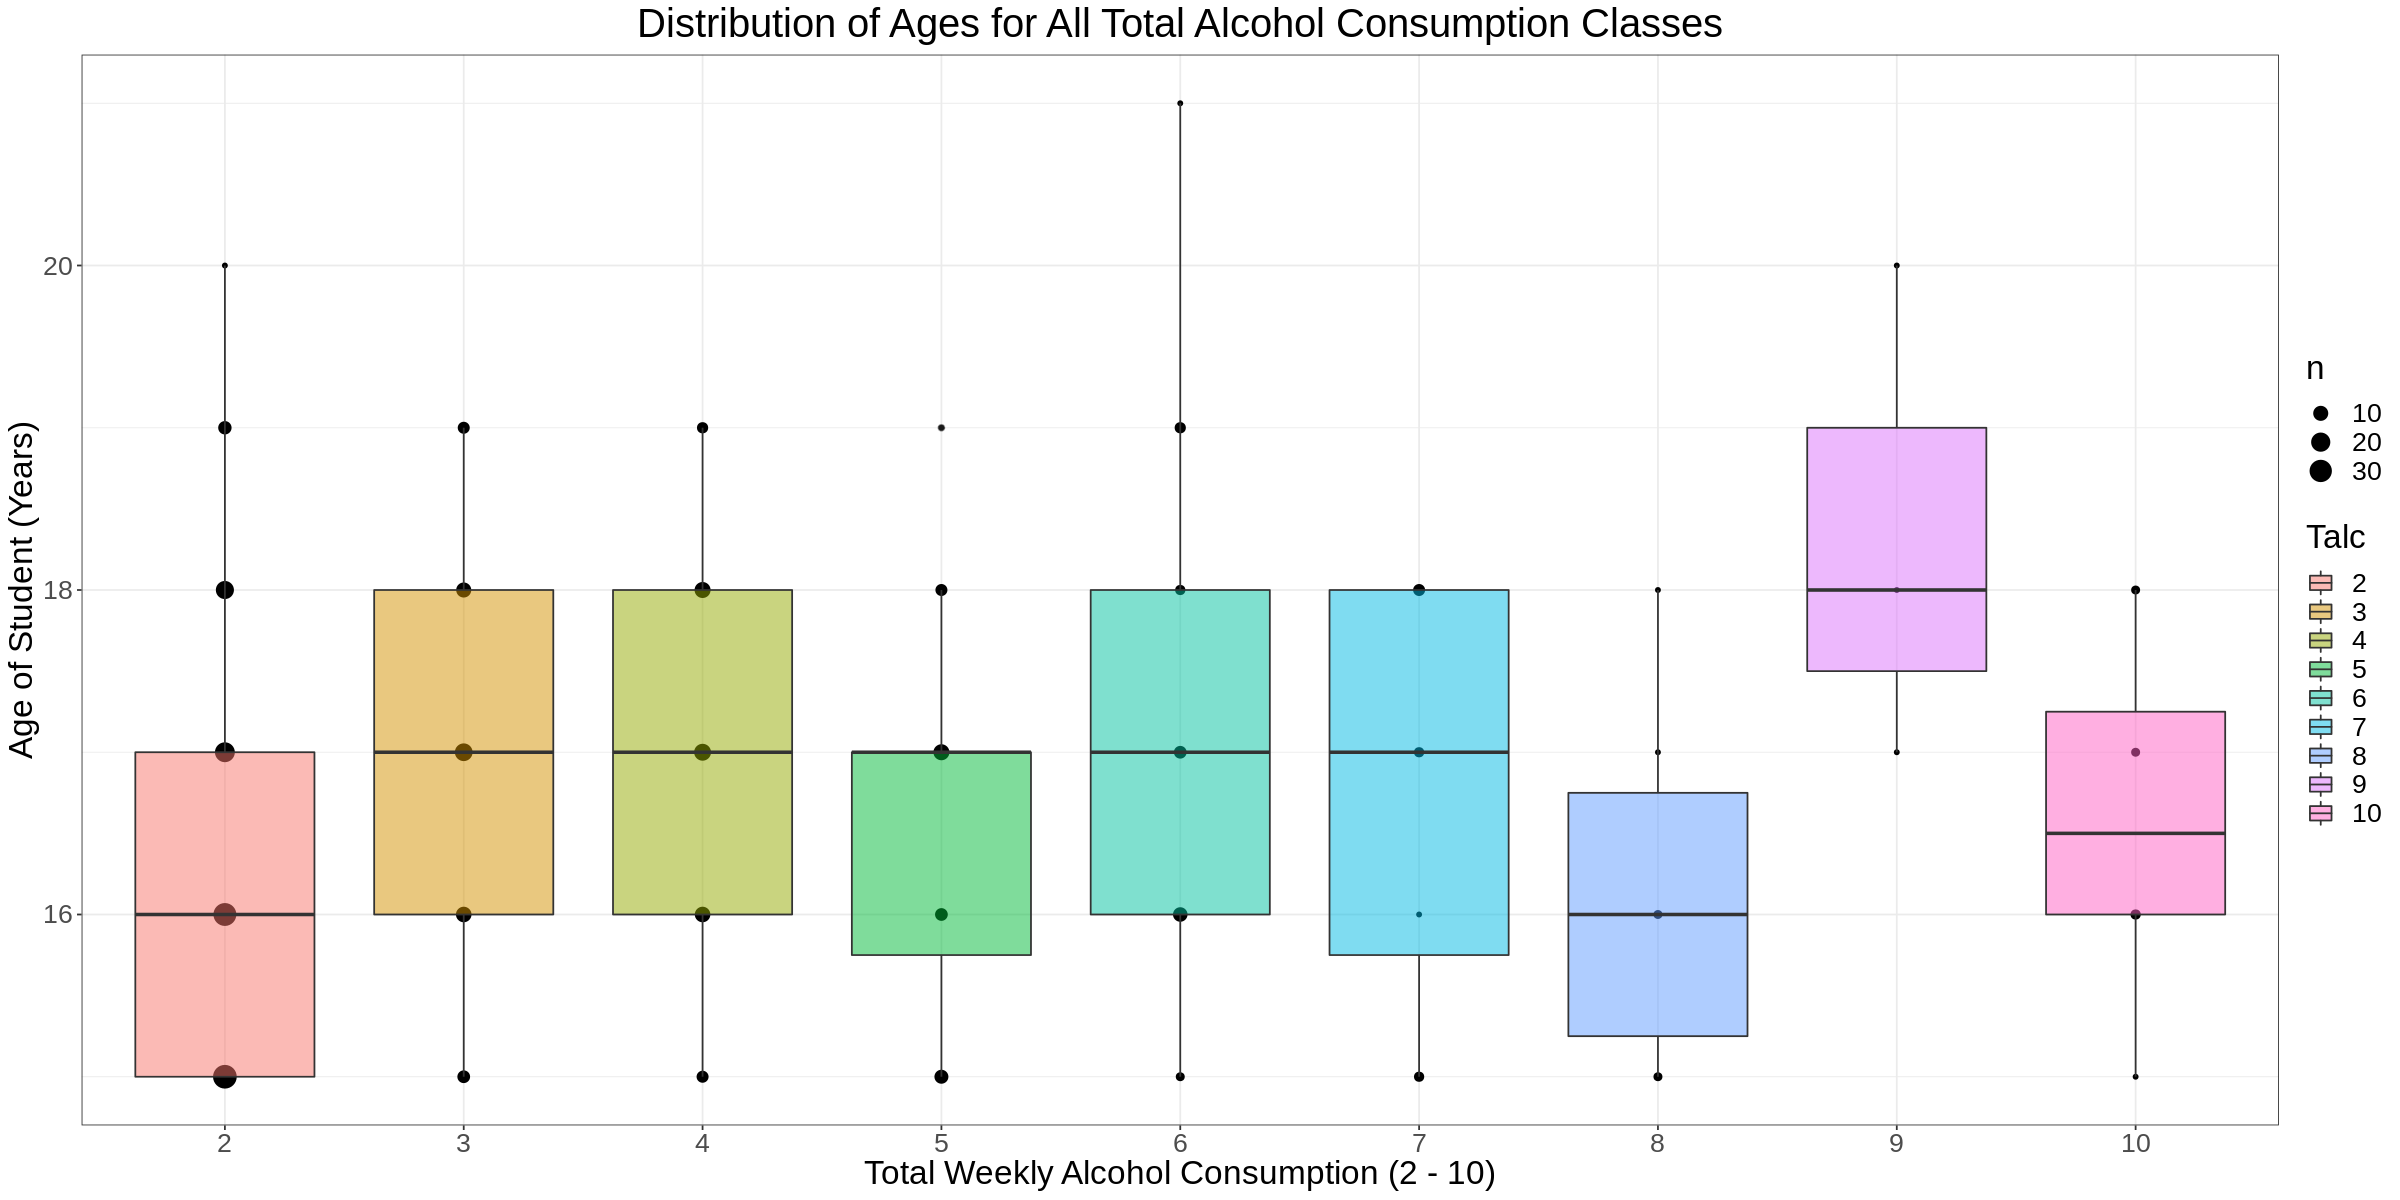

In [13]:
sac_train_age_bar_chart_data <- sac_train |>
    select(Talc, age)

options(repr.plot.width = 20, repr.plot.height = 10) 
sac_train_age_bar_chart <- sac_train_age_bar_chart_data |>
     ggplot(aes(x = Talc, y = age)) + 
     geom_count(aes(x = Talc, y = age)) +
     geom_boxplot(aes(fill = Talc), alpha = 0.5) +
     labs(x = "Total Weekly Alcohol Consumption (2 - 10)",
          y = "Age of Student (Years)",
          title = "Distribution of Ages for All Total Alcohol Consumption Classes") +
     theme(plot.title = element_text(hjust = 0.5),
           text = element_text(size = 20))


sac_train_age_bar_chart

It appears generally, students in the lowest `Talc` group are younger.

#### Investigating Number of Student Abscences in Different `Talc` Groups

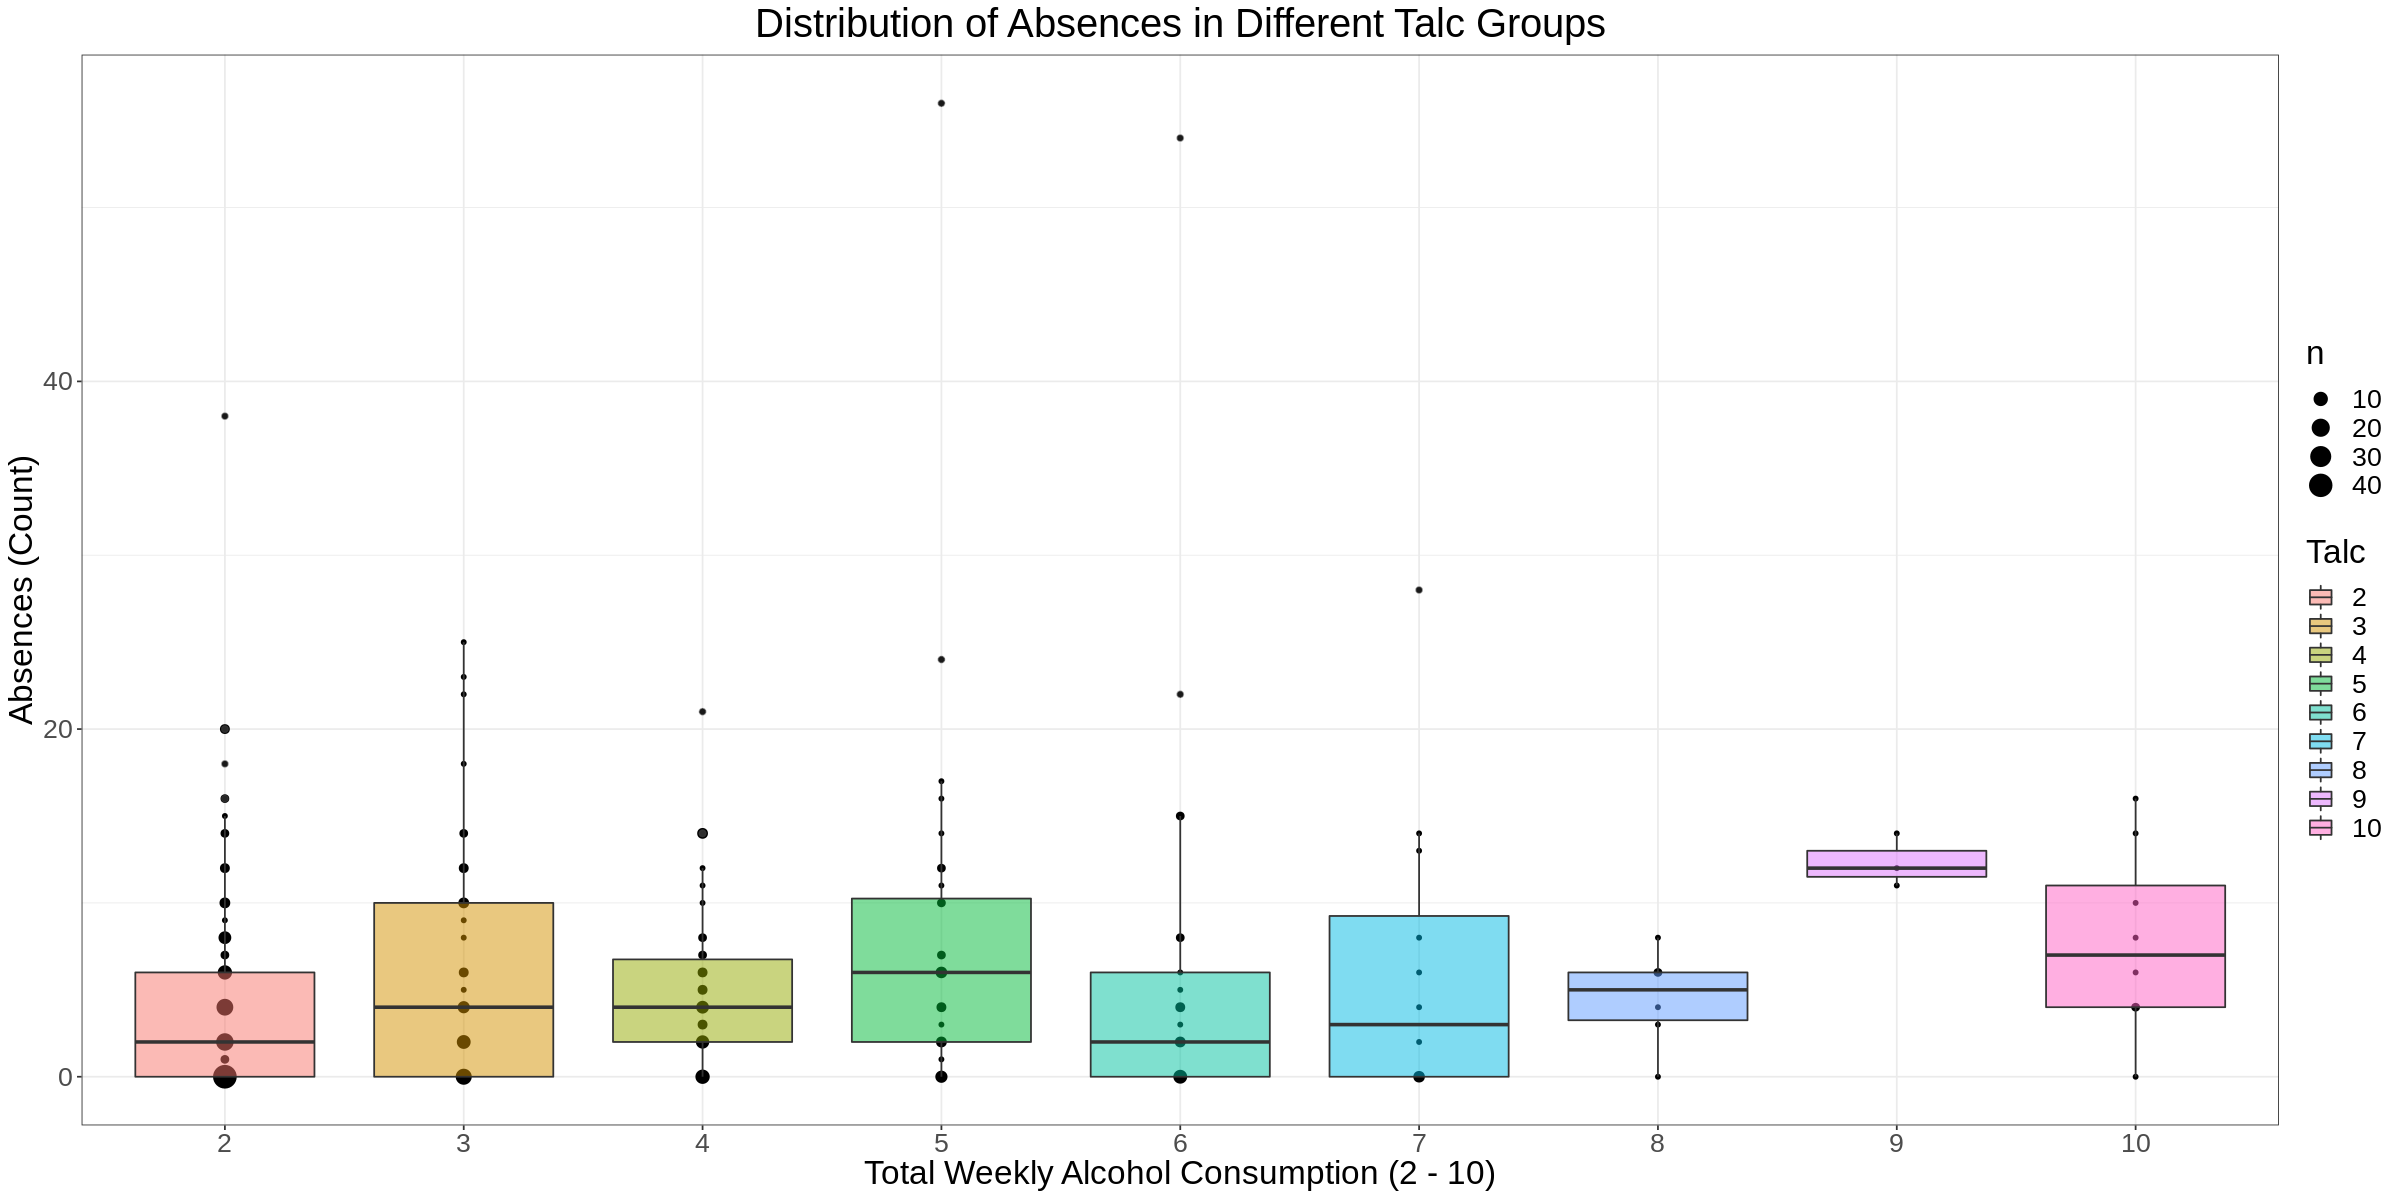

In [14]:
sac_train_absences_scatter_data <- sac_train |>
    select(Talc, absences)

sac_train_abscences_plot <- sac_train_absences_scatter_data |>
    ggplot() +
    geom_count(aes(x = Talc, y = absences)) +
    geom_boxplot(aes(x = Talc, y = absences, fill = Talc), alpha = 0.5) +
     labs(x = "Total Weekly Alcohol Consumption (2 - 10)",
          y = "Absences (Count)",
          title = "Distribution of Absences in Different Talc Groups") +
     theme(plot.title = element_text(hjust = 0.5),
           text = element_text(size = 20))


sac_train_abscences_plot

Again, there is a slight trend of more absences in higher `Talc` groups.

#### Investigating Degree of Student Failures Different `Talc` Groups

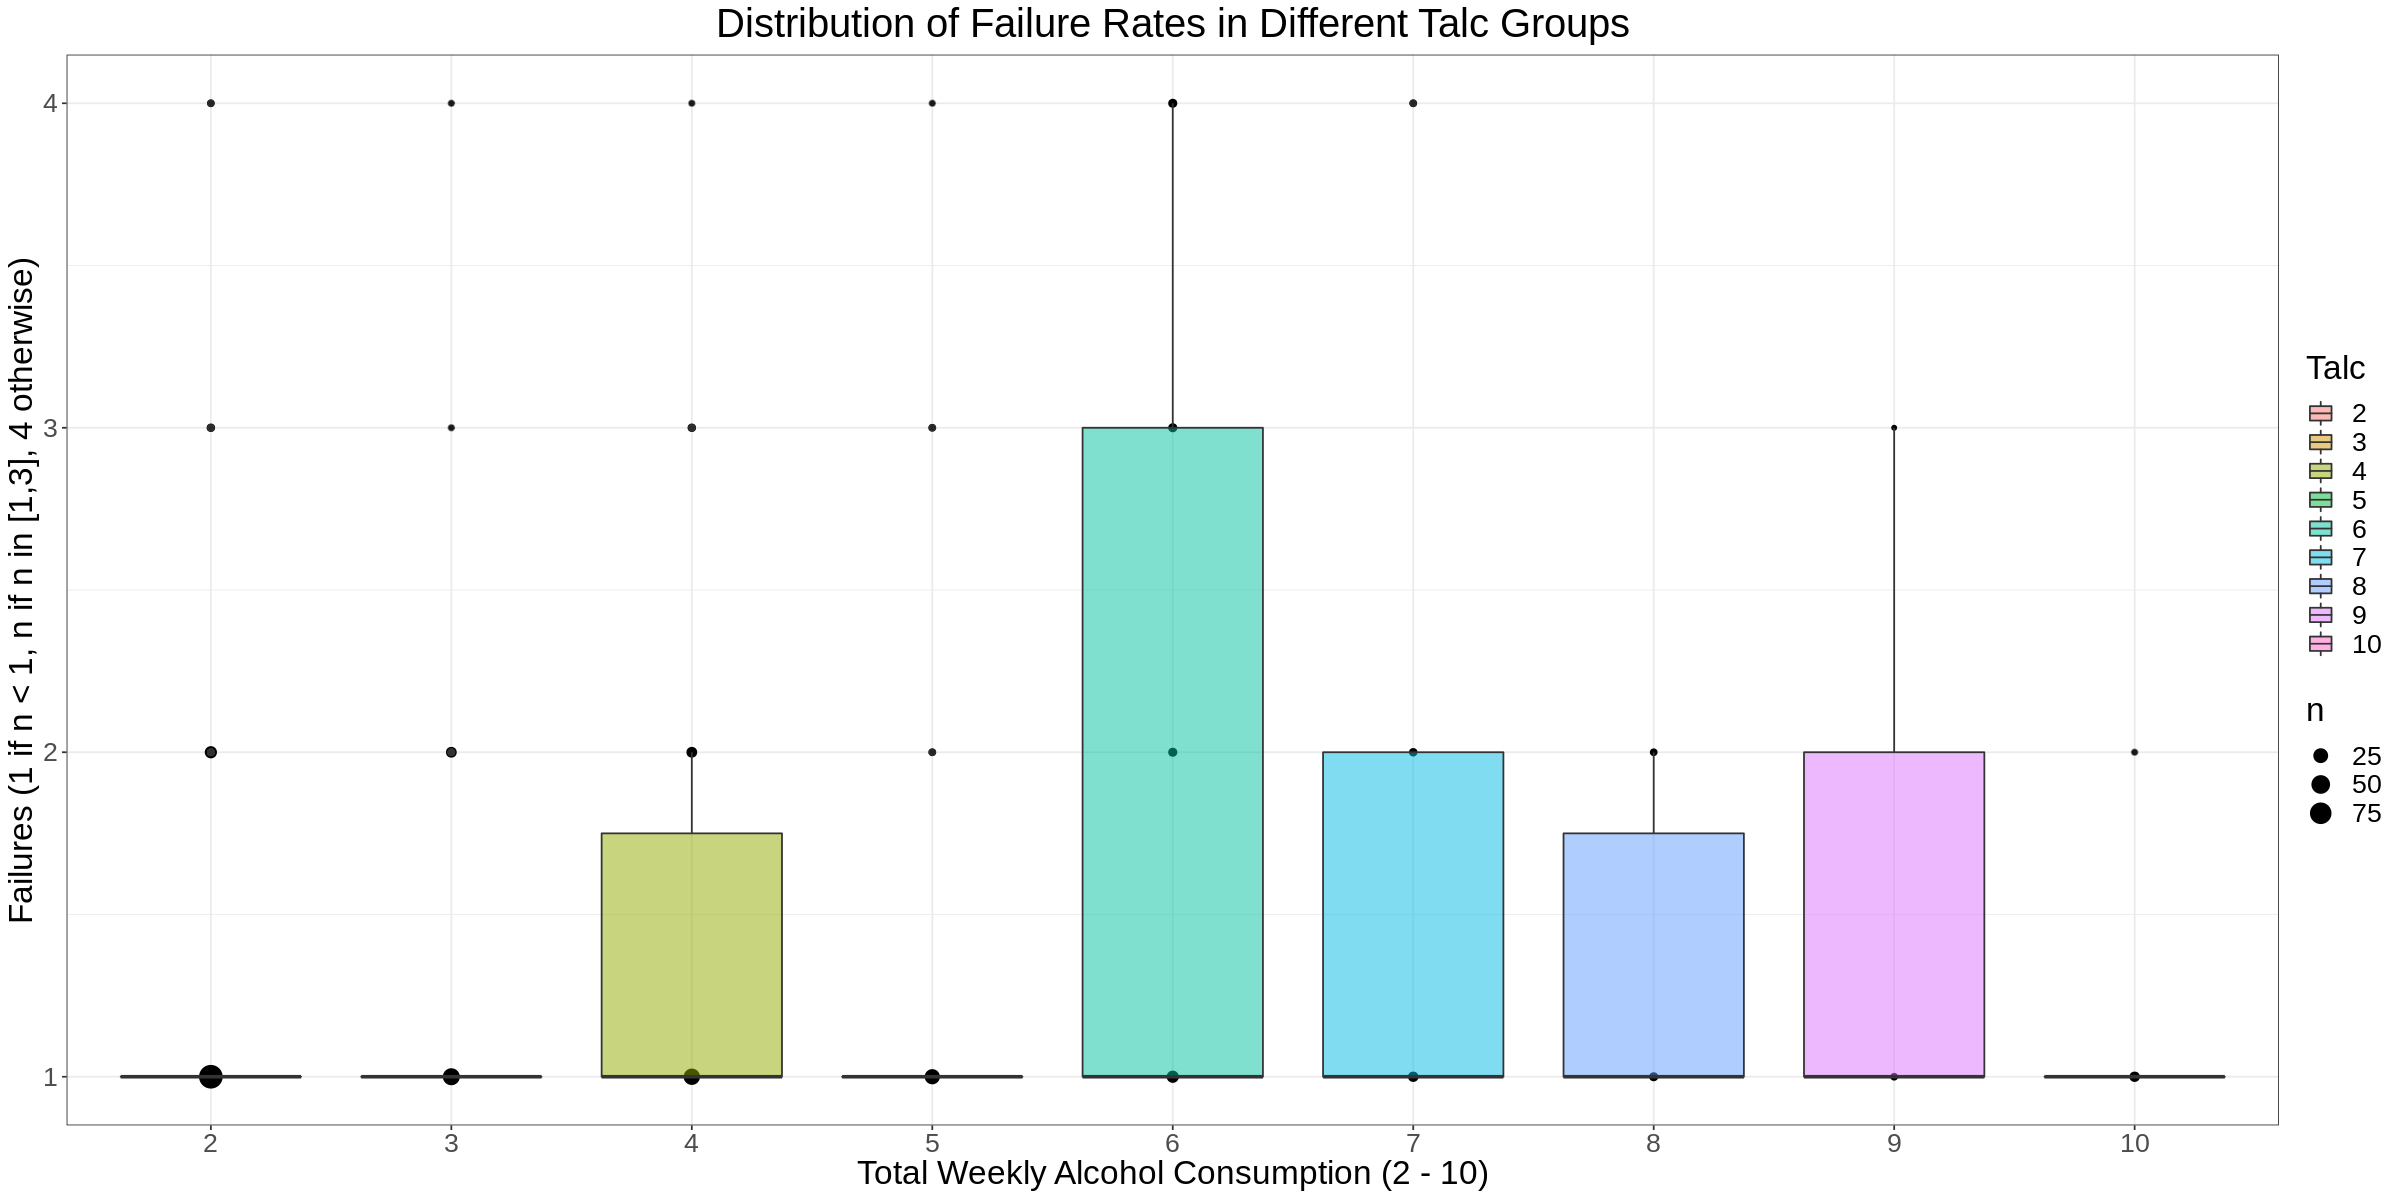

In [15]:
sac_train_failures_scatter_data <- sac_train |>
    select(Talc, failures) 

sac_train_failures_scatter_data$failures <- as.numeric(sac_train_failures_scatter_data$failures)

sac_train_failure_plot <- sac_train_failures_scatter_data |>
    ggplot() +
    geom_count(aes(x = Talc, y = failures)) +
    geom_boxplot(aes(x = Talc, y = failures, fill = Talc), alpha = 0.5) +
     labs(x = "Total Weekly Alcohol Consumption (2 - 10)",
          y = "Failures (1 if n < 1, n if n in [1,3], 4 otherwise)",
          title = "Distribution of Failure Rates in Different Talc Groups") +
     theme(plot.title = element_text(hjust = 0.5),
           text = element_text(size = 20))

sac_train_failure_plot

It appears that higher `Talc` groups tend to also have more failures.

#### Investigating Student Grade Distribution in Different `Talc` Groups

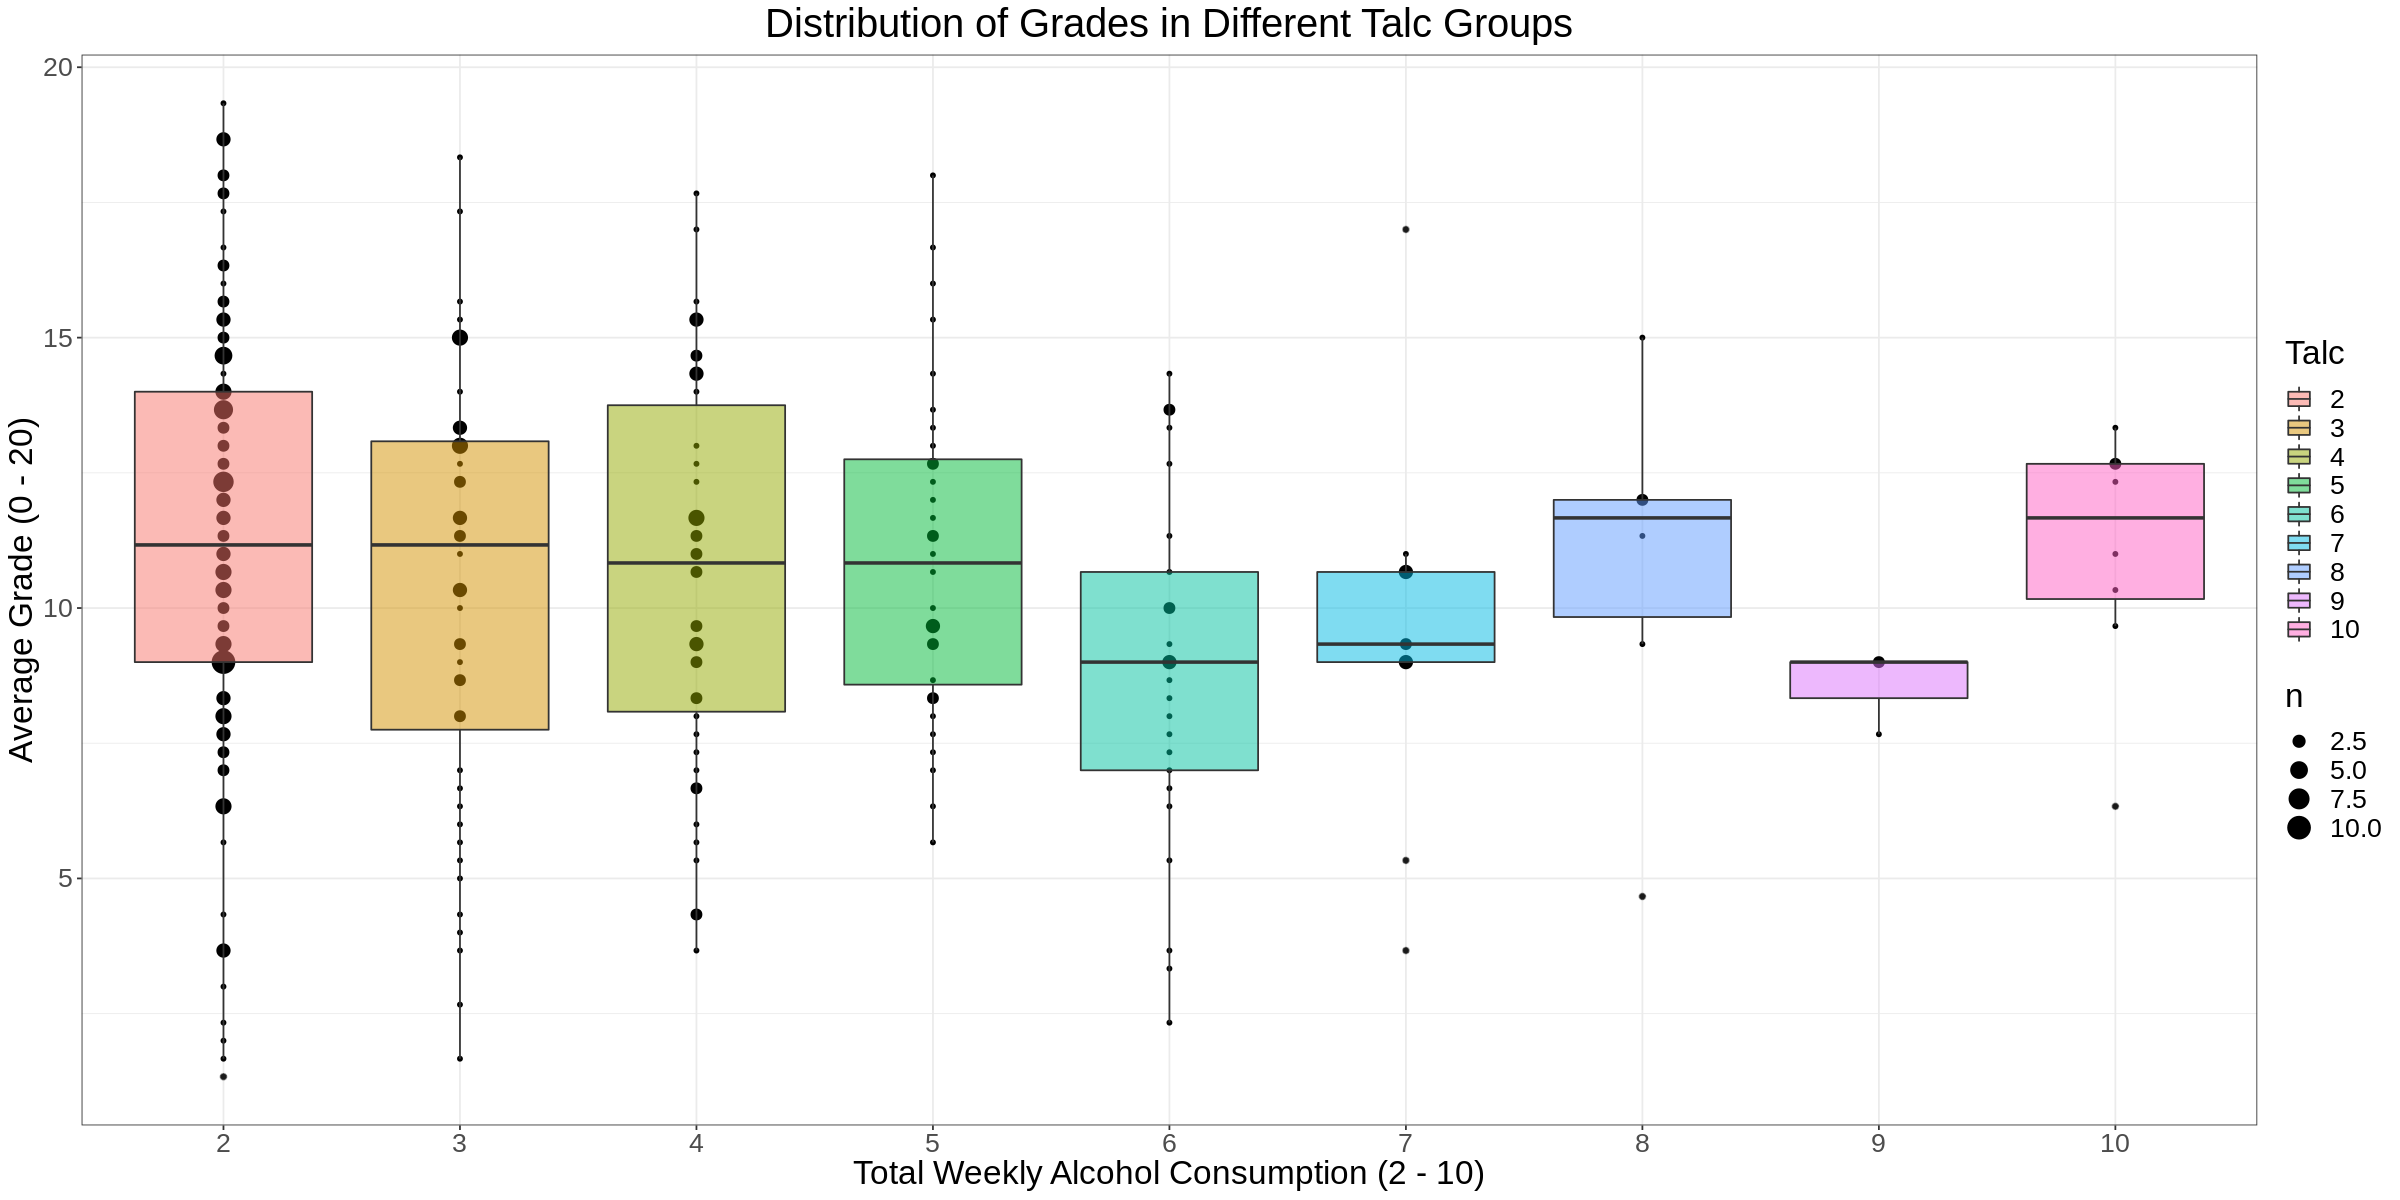

In [16]:
sac_train_avg_grades_scatter_data <- sac_train |>
    select(Talc, AvgG) 

sac_train_avg_grades_scatter <- sac_train_avg_grades_scatter_data |>
    ggplot() +
    geom_count(aes(x = Talc, y = AvgG)) +
    geom_boxplot(aes(x = Talc, y = AvgG, fill = Talc), alpha = 0.5) +
     labs(x = "Total Weekly Alcohol Consumption (2 - 10)",
          y = "Average Grade (0 - 20)",
          title = "Distribution of Grades in Different Talc Groups") +
     theme(plot.title = element_text(hjust = 0.5),
           text = element_text(size = 20))

sac_train_avg_grades_scatter

Here, it appears that students in lower `Talc` groups have slightly higher `AvgG`.

**In summary**, the trends appear to be weakly related. However, the aim is that the combination is sufficient for classification.

***
## **Methods**
***



#### Building the Classifier with Optimal Neighbors

The data analysis to be conducted relies on the package `tidymodels`.

A model specification will be created with the model `nearest_neighbour()`, the weight-function `rectangular`, the engine `kknn` and the mode `classification`. The `neighbors` (`K`) argument will be set to `tune()`. 

Next, a recipe will be created. `Talc` will be the outcome variable and all other variables will be predictors. Data will be preprocessed to standardize the mean of all variables to 0 (scaling, `step_scale`) and the standard deviation of all variables to 1 (centering, `step_centre`). 

The model and recipe will be combined in a `workflow` object.

A 5-fold cross-validation set of the training data will be made using `vfold_cv` with stratification of `Talc`. `K` values of 2 - 50 will be added to a tibble for `tune_grid`.

The validation set will then be fit to the model using `tune_grid` and the k-value tibble. `collect_metrics` will be used to obtain accuracy measures. 

A scatterplot of `K` vs. `Accuracy` will be generated. From the analysis, the `K` providing maximum accuracy will be used in the final model. 

#### Assessing the Classifier on Non-Training Data

The `workflow` object created earlier will be modified so that the optimal `K` is set. The workflow will be fit to the full training data set. 

The optimized classifier will be used to predict the `Talc` classes in the test set. 

`bind_cols()` will be used to add the predictions the original test dataset. 

`metrics` and `conf_mat` will be then used to judge the ability of the classifier to accurately classify the test set. 

***
## **Expected Outcomes and Significance**
***

#### Expected Findings

The aim is to develop a classifier that accurately predict a student's severity of alcohol consumption based on non-self-reported factors, and this would be achieved by finding a classifier with high accuracy. The minimum goal is to have the accuracy be higher than that of random classification.

#### Potential Impacts

This model could help academic institutions estimate alcohol consumption in student populations. This could lead to better distribution of resources, helping students from developing alcoholism or aiding students currently suffering. 

#### Potential Future Questions

1. Would the accuracy of the model change with a different combination of predictor variables?
2. Which non-self-reported factor is the most correlated to excessive alcohol consumption?
3. Is this model accurate in non-Portuguese non-secondary school student populations?

## **References**

[1] Cortez, P., & Silva, A. M. G. (2008). Using data mining to predict secondary school student performance.

[2] Wei, Q. (2017). Binge drinking and academic performance, engagement, aspirations, and expectations: A longitudinal analysis among secondary school students in the COMPASS study. Health Promotion and Chronic Disease Prevention in Canada: Research, Policy and Practice, 37(11), 376.

[3] Mekonen, T., Fekadu, W., Chane, T., & Bitew, S. (2017). Problematic alcohol use among university students. Frontiers in psychiatry, 8, 86.